<a href="https://colab.research.google.com/github/emilianodesu/SIAFI-2026-1/blob/main/ML/2_5_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Machine Learning

## 2.5 Decision Trees and Random Forests

### 2.5.1 Decision Trees

*Decision trees* are versatile machine learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets. For example, in Introduction to Data Science you trained a `DecisionTreeRegressor` model on the California housing dataset, fitting it perfectly (actually, overfitting it).

Decision trees are also the fundamental components of random forests (see next section), which are among the most powerful machine learning algorithms available today.

#### 2.5.1.1 Training and Visualizing a Decision Tree

To understand decision trees, let’s build one and take a look at how it makes predictions. The following code trains a `DecisionTreeClassifier` on the iris dataset:

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


You can visualize the trained decision tree by first using the `export_graphviz()` function to output a graph definition file called `iris_tree.dot`:

In [2]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file="iris_tree.dot",
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Then you can use `graphviz.Source.from_file()` to load and display the file in a Jupyter notebook:

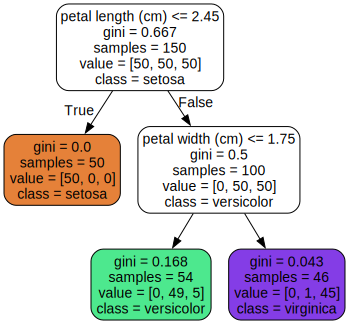

In [3]:
from graphviz import Source

Source.from_file("iris_tree.dot")

*Graphviz* is an open source graph visualization software package. It also includes a `dot` command-line tool to convert *.dot* files to a variety of formats, such as PDF or PNG.

```bash
dot -Tpng "my_iris_tree.dot" -o "my_iris_tree.png"
```

#### 2.5.1.2 Making Predictions

Suppose you find an iris flower and you want to classify it based on its petals. You start at the *root node* (depth 0, at the top): this node asks whether the flower’s petal length is smaller than 2.45 cm. If it is, then you move down to the root’s left child node (depth 1, left). In this case, it is a *leaf node* (i.e., it does not have any child nodes), so it does not ask any questions: simply look at the predicted class for that node, and the decision tree predicts that your flower is an *Iris setosa* (`class=setosa`).

Now suppose you find another flower, and this time the petal length is greater than 2.45 cm. You again start at the root but now move down to its right child node (depth 1, right). This is not a leaf node, it’s a *split node*, so it asks another question: is the petal width smaller than 1.75 cm? If it is, then your flower is most likely an *Iris versicolor* (depth 2, left). If not, it is likely an *Iris virginica* (depth 2, right). It’s really that simple.

**Note:** One of the many qualities of decision trees is that they require very little data preparation. In fact, they don’t require feature scaling or centering at all.

A node’s `samples` attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A node’s `value` attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 *Iris setosa*, 1 *Iris versicolor*, and 45 *Iris virginica*. Finally, a node’s `gini` attribute measures its *Gini impurity*: a node is “pure” (`gini=0`) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to *Iris setosa* training instances, its Gini impurity is 0. Conversely, the other nodes all apply to instances of multiple classes, so they are “impure”. The following equation shows how the training algorithm computes the Gini impurity $G_i$ of the $i$-th node. The more classes and the more mixed they are, the larger the impurity. For example, the depth-2 left node has a Gini impurity equal to $1 – (0/54)^2 – (49/54)^2 – (5/54)^2 ≈ 0.168$.

**Gini Impurity Equation:**

$$G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2$$

In this equation:

* $G_i$ is the Gini impurity of node $i$.
* $p_{i,k}$ is the proportion of training instances in node $i$ that belong to class $k$.
* $n$ is the total number of classes.

The next figure shows this decision tree’s decision boundaries. The thick vertical line represents the decision boundary of the root node (depth 0): petal length = 2.45 cm. Since the lefthand area is pure (only *Iris setosa*), it cannot be split any further. However, the righthand area is impure, so the depth-1 right node splits it at petal width = 1.75 cm (represented by the dashed line). Since `max_depth` was set to 2, the decision tree stops right there. If you set `max_depth` to 3, then the two depth-2 nodes would each add another decision boundary (represented by the two vertical dotted lines).

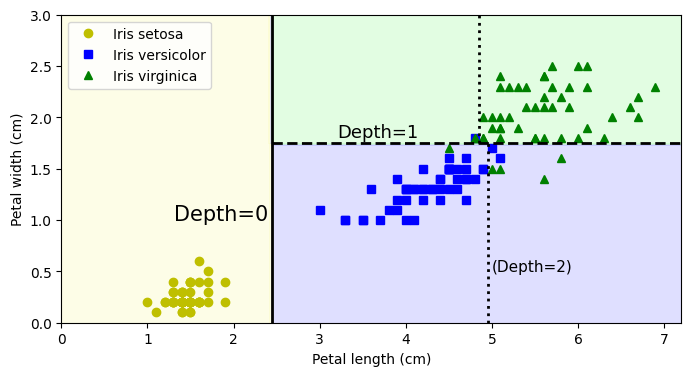

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# extra code – just formatting details
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# extra code – this section beautifies Figure 5–2
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis((0, 7.2, 0, 3))
plt.legend()

plt.show()

Decision trees are intuitive, and their decisions are easy to interpret. Such models are often called *white box models*. In contrast, as you will see, random forests and neural networks are generally considered *black box models*. They make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made. For example, if a neural network says that a particular person appears in a picture, it is hard to know what contributed to this prediction: Did the model recognize that person’s eyes? Their mouth? Their nose? Their shoes? Or even the couch that they were sitting on? Conversely, decision trees provide nice, simple classification rules that can even be applied manually if need be (e.g., for flower classification). The field of *interpretable* ML aims at creating ML systems that can explain their decisions in a way humans can understand. This is important in many domains, for example in healthcare, to let a doctor review the diagnosis; in finance, to let analysts understand the risks; in a judicial system, to let a human make the final call; or in human resources, to ensure decisions aren’t biased.

#### 2.5.1.3 Estimating Class Probabilities

A decision tree can also estimate the probability that an instance belongs to a particular class *k*. First it traverses the tree to find the leaf node for this instance, and then it returns the proportion of instances of class *k* among the training instances that would also reach this leaf node. For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the decision tree outputs the following probabilities: 0% for *Iris setosa* (0/54), 90.7% for *Iris versicolor* (49/54), and 9.3% for *Iris virginica* (5/54). And if you ask it to predict the class, it outputs Iris versicolor (class 1) because it has the highest probability. Let’s check this:

In [5]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

Perfect! Notice that the estimated probabilities would be identical anywhere else in the bottom-right rectangle of the figure above, for example, if the petals were 6 cm long and 1.5 cm wide (even though it seems obvious that it would most likely be an *Iris virginica* in this case).

#### 2.5.1.4 The CART Training Algorithm

Scikit-Learn uses the *Classification and Regression Tree* (CART) algorithm to train decision trees (also called “growing” trees). The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$ (e.g., “petal length ≤ 2.45 cm”). How does it choose $k$ and $t_k$? It searches for the pair ($k$, $t_k$) that produces the purest subsets, weighted by their size. The following equation gives the cost function that the algorithm tries to minimize.

**CART Cost Function for classification:**

$J(k, t_k) = \frac{m_{\text{left}}}{m} \text{G}_{\text{left}} + \frac{m_{\text{right}}}{m} \text{G}_{\text{right}}$

Where:
* $G_{\text{left/right}}$ measures the impurity of the left/right subset.
* $m_{\text{left/right}}$ is the number of instances in the left/right subset.
* $m = m_{\text{left}} + m_{\text{right}}$

Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the `max_depth` hyperparameter), or if it cannot find a split that will reduce impurity. A few other hyperparameters (described in a moment) control additional stopping conditions: `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes`, and more.

**Warning**: As you can see, the CART algorithm is a *greedy algorithm*: it greedily searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a solution that’s reasonably good but not guaranteed to be optimal.

Unfortunately, finding the optimal tree is known to be an NP-complete problem.⁠It requires $O(\text{exp(m)})$ time,⁠ making the problem intractable even for small training sets. This is why we must settle for a “reasonably good” solution when training decision trees.

#### 2.5.1.5 Entropy

By default, the `DecisionTreeClassifier` class uses the Gini impurity measure, but you can select the *entropy* impurity measure instead by setting the `criterion` hyperparameter to `"entropy"`. The concept of entropy originated in thermodynamics as a measure of molecular disorder: entropy approaches zero when molecules are still and well ordered. Entropy later spread to a wide variety of domains, including in Shannon’s information theory, where it measures the average information content of a message. Entropy is zero when all messages are identical. In machine learning, entropy is frequently used as an impurity measure: a set’s entropy is zero when it contains instances of only one class. The next equation shows the definition of the entropy of the $i$-th node. For example, the depth-2 left node in the following has an entropy equal to $–(49/54) \log_2 (49/54) – (5/54) \log_2 (5/54) \approx 0.445$.

**Entropy Equation:**

$$H_i = - \sum_{k=1}^{n} p_{i,k} \log_2 (p_{i,k})$$

So, should you use Gini impurity or entropy? The truth is, most of the time it does not make a big difference: they lead to similar trees. Gini impurity is slightly faster to compute, so it is a good default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees.⁠

#### 2.5.1.6 Regularization Hyperparameters

Decision trees make very few assumptions about the training data (as opposed to linear models, which assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely—indeed, most likely overfitting it. Such a model is often called a *nonparametric model*, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a *parametric model*, such as a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, you need to restrict the decision tree’s freedom during training. As you know by now, this is called regularization. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the decision tree. In Scikit-Learn, this is controlled by the `max_depth` hyperparameter. The default value is None, which means unlimited. Reducing `max_depth` will regularize the model and thus reduce the risk of overfitting.

The `DecisionTreeClassifier` class has a few other parameters that similarly restrict the shape of the decision tree:

* `max_features`: Maximum number of features that are evaluated for splitting at each node.
* `max_leaf_nodes`: Maximum number of leaf nodes.
* `min_samples_split`: Minimum number of samples a leaf node must have to be created.
* `min_samples_leaf`: Minimum number of samples a leaf node must have to be created.
* `min_weight_fraction_leaf`: Same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances.
* `min_impurity_decrease`: Only split a node if this split results in at least this reduction in impurity.
* `ccp_alpha`: Controls *minimal cost-complexity pruning* (MCCP), i.e. pruning subtrees that don't reduce impurity enough compared to their number of leaves; a larger `ccp_alpha` value leads to more pruning, resulting in a smaller tree (the default is 0- no pruning).

To limit the model’s complexity and thereby regularize the model, you can increase `min_*` hyperparameters or `ccp_alpha`, or decrease `max_*` hyperparameters. Tuning `max_depth` is usually a good default: it provides effective regularization, and it keeps the tree small and easy to interpret. Setting `min_samples_leaf` is also a good idea, especially for small datasets. And `max_features` is great when working with high-dimensional datasets.

**Note**: Other algorithms work by first training the decision tree without restrictions, then *pruning* (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant. Standard statistical tests, such as the χ2 test (chi-squared test), are used to estimate the probability that the improvement is purely the result of chance (which is called the *null hypothesis*). If this probability, called the *p*-value, is higher than a given threshold (typically 5%, controlled by a hyperparameter), then the node is considered unnecessary and its children are deleted. The pruning continues until all unnecessary nodes have been pruned.

Let’s test regularization on the moons dataset: this is a toy dataset for binary classification in which the data points are shaped as two interleaving crescent moons. You can generate this dataset using the `make_moons()` function.

We’ll train one decision tree without regularization, and another with `min_samples_leaf=5`. Here’s the code; The next figure shows the decision boundaries of each tree:

In [7]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


The unregularized model on the left is clearly overfitting, and the regularized model on the right will probably generalize better. We can verify this by evaluating both trees on a test set generated using a different random seed:

In [8]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [9]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

Indeed, the second tree has a better accuracy on the test set.

#### 2.5.1.7 Regression

Decision trees are also capable of performing regression tasks. While linear regression only works well with linear data, decision trees can fit all sorts of complex datasets. Let’s build a regression tree using Scikit-Learn’s `DecisionTreeRegressor` class, training it on a noisy quadratic dataset with `max_depth=2`:

In [10]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

rng = np.random.default_rng(seed=42)
X_quad = rng.random((200, 1)) - 0.5  # a single random input feature
y_quad = X_quad ** 2 + 0.025 * rng.standard_normal((200, 1))

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


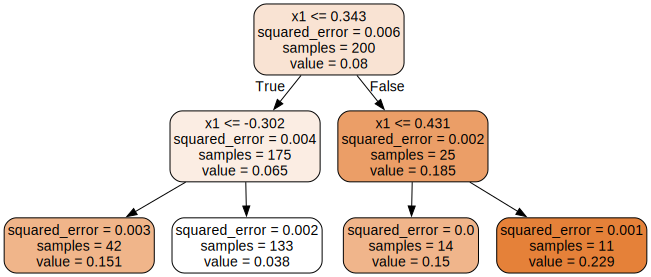

In [11]:
# extra code – we've already seen how to use export_graphviz()
export_graphviz(
    tree_reg,
    out_file="my_regression_tree.dot",
    feature_names=["x1"],
    rounded=True,
    filled=True
)
Source.from_file("my_regression_tree.dot")

This tree looks very similar to the classification tree you built earlier. The main difference is that instead of predicting a class in each node, it predicts a value. For example, suppose you want to make a prediction for a new instance with $x_1 = 0.2$. The root node asks whether $x_1 \leq 0.343$. Since it is, the algorithm goes to the left child node, which asks whether $x_1 \leq –0.302$. Since it is not, the algorithm goes to the right child node. This is a leaf node, and it predicts `value=0.038`. This prediction is the average target value of the 133 training instances associated with this leaf node, and it results in a mean squared error equal to 0.002 over these 133 instances.

This model’s predictions are represented on the left inthe next figure. If you set `max_depth=3`, you get the predictions represented on the right. Notice how the predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.

In [12]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [13]:
tree_reg.tree_.threshold

array([ 0.34304063, -0.30182856, -2.        , -2.        ,  0.43140428,
       -2.        , -2.        ])

In [14]:
tree_reg2.tree_.threshold

array([ 0.34304063, -0.30182856, -0.41395289, -2.        , -2.        ,
        0.21817657, -2.        , -2.        ,  0.43140428,  0.39480372,
       -2.        , -2.        ,  0.46470371, -2.        , -2.        ])

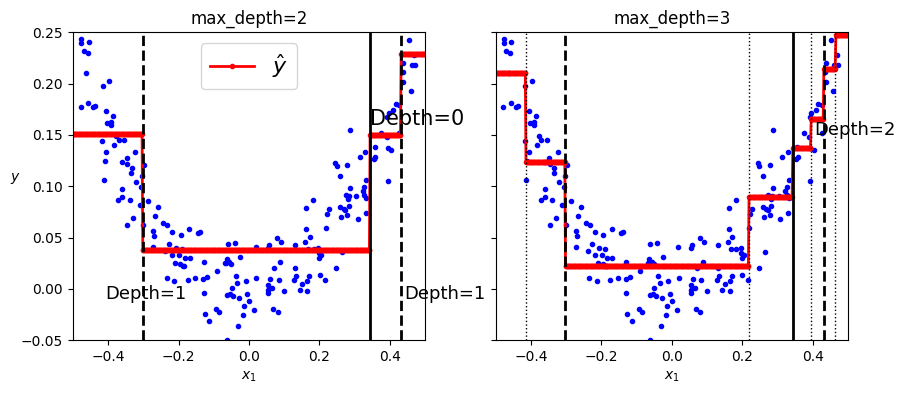

In [15]:
def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

plt.show()

The CART algorithm works as described earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE.

**CART cost function for regression:**
$$ J(k,t_k) = \frac{m_{\text{left}}}{m} \text{MSE}_{\text{left}} + \frac{m_{\text{right}}}{m} \text{MSE}_{\text{right}} $$

Where:

* $\text{MSE}_{\text{node}} = \frac{1}{m_{\text{node}}} \sum_{i \in \text{node}} (\bar{y}_{\text{node}} - y^{(i)})^2$ is the mean squared error of the instances in the node.
* $\bar{y}_{\text{node}} = \frac{1}{m_{\text{node}}} \sum_{i \in \text{node}} y^{(i)}$ is the average target value of the instances in the node.

Just like for classification tasks, decision trees are prone to overfitting when dealing with regression tasks. Without any regularization (i.e., using the default hyperparameters), you get the predictions on the left. These predictions are obviously overfitting the training set very badly. Just setting `min_samples_leaf=10` results in a much more reasonable model, represented on the right.

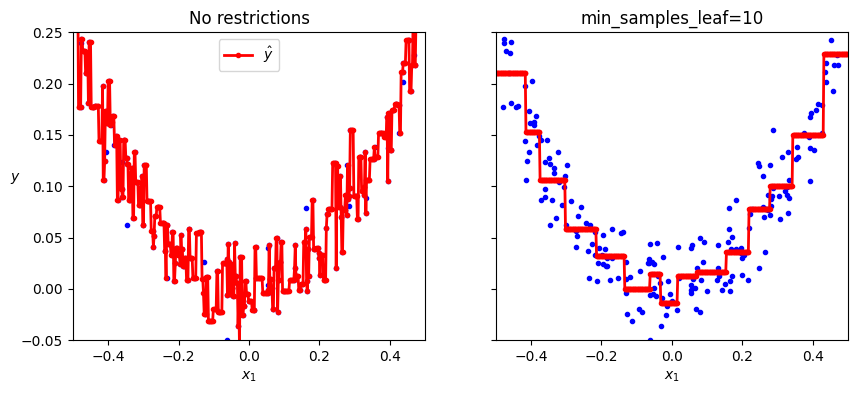

In [16]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis((-0.5, 0.5, -0.05, 0.25))
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis((-0.5, 0.5, -0.05, 0.25))
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

plt.show()

### 2.5.2 Random Forests

The main issue with decision trees is that they have quite a high variance: small changes to the hyperparameters or to the data may produce very different models. In fact, since the training algorithm used by Scikit-Learn is stochastic—it randomly selects the set of features to evaluate at each node—even retraining the same decision tree on the exact same data may produce a very different model, such as the one represented in the next figure (unless you set the `random_state` hyperparameter). As you can see, it looks very different from the previous decision tree.

In [17]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_iris, y_iris)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,40
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


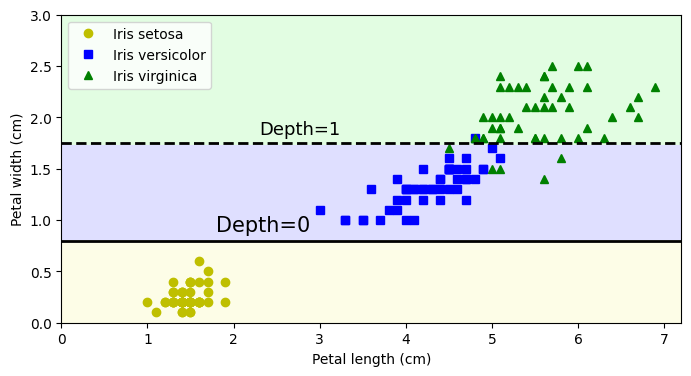

In [18]:
plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis((0, 7.2, 0, 3))
plt.legend()

plt.show()

Luckily, by averaging predictions over many trees, it’s possible to reduce variance significantly. Such an *ensemble* of trees is called a *random forest*, and it’s one of the most powerful types of models available today.

**Note**: One way to get a diverse set of classifiers is to use the same training algorithm for every predictor but train them on different random subsets of the training set. When sampling is performed with replacement,⁠ this method is called *bagging* (short for *bootstrap aggregating*). When sampling is performed without replacement, it is called *pasting*.⁠

A random forest⁠ is an ensemble of decision trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. You can use the `RandomForestClassifier` class, which is convenient and optimized for decision trees⁠ (similarly, there is a `RandomForestRegressor` class for regression tasks). The following code trains a random forest classifier with 500 trees, each limited to maximum 16 leaf nodes, using all available CPU cores:

```python
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
```

With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The `RandomForestClassifier` class introduces extra randomness when growing trees: instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. By default, it samples $\sqrt{n}$ features (where $n$ is the total number of features). The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model.

#### **For Further Exploration**

Check out these resources to deepen your understanding of decision trees and random forests:

* [Decision and Classification Trees, Clearly Explained!!!](https://youtu.be/_L39rN6gz7Y?si=Ug9mZmOwIMnI-rvc)
* [Regression Trees, Clearly Explained!!!](https://youtu.be/g9c66TUylZ4?si=eSrW--HHX2-ShSMw)
* [StatQuest: Random Forests Part 1 - Building, Using and Evaluating](https://youtu.be/J4Wdy0Wc_xQ?si=eaDk6EFcrBZkKGpM)
* [StatQuest: Random Forests Part 2: Missing data and clustering](https://youtu.be/sQ870aTKqiM?si=NCMYw1JCHZgPTxMb)

---
**References:**

Disclaimer: Some of the material in this notebook is adapted from other sources. These references are provided for further reading and to acknowledge the original authors.

* Chapter 5 and 6 Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurélien Géron, [3rd edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)